In [1]:
import sys, os
sys.path.insert(0, '..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
from tqdm import tqdm, trange
import gc
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.graph_utils import get_edges_fastknn_faiss
from utils.score import statistical_parity
from utils.snakemake_utils import FileResources
import seaborn as sns
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

In [4]:
y = pokec_data.SmallPokecDataFrame(group_col='gender').get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [5]:
sp_score, roc_score, gini_score = {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/residual_2_vec/normalized_features_reduced_pokec/'
! ls /data/sg/ashutiwa/residual_2_vec/normalized_features_reduced_pokec/

pokec_crosswalk_adj.npz			   pokec_gat_node2vec_embs.npy
pokec_crosswalk_gat_node2vec_embs.npy	   pokec_gat_node2vec.h5
pokec_crosswalk_gat_node2vec.h5		   pokec_gat_nodevec.h5
pokec_crosswalk_gat_nodevec.h5		   pokec_gat_r2v_node2vec_embs.npy
pokec_crosswalk_gat_r2v_node2vec_embs.npy  pokec_gat_r2v_node2vec.h5
pokec_crosswalk_gat_r2v_node2vec.h5	   pokec_gat_r2v_nodevec.h5
pokec_crosswalk_gat_r2v_nodevec.h5	   pokec_gcn_node2vec_embs.npy
pokec_crosswalk_gcn_node2vec_embs.npy	   pokec_gcn_node2vec.h5
pokec_crosswalk_gcn_node2vec.h5		   pokec_gcn_nodevec.h5
pokec_crosswalk_gcn_nodevec.h5		   pokec_gcn_r2v_node2vec_embs.npy
pokec_crosswalk_gcn_r2v_node2vec_embs.npy  pokec_gcn_r2v_node2vec.h5
pokec_crosswalk_gcn_r2v_node2vec.h5	   pokec_gcn_r2v_nodevec.h5
pokec_crosswalk_gcn_r2v_nodevec.h5	   polbooks.gml


# distributions of positive and negative edgeswith dot product

In [6]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

In [7]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

# GCN ( baseline)

In [8]:
model = "GCN_baseline"
emb = np.load(DATA_ROOT + 'pokec_gcn_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 234914.66it/s]


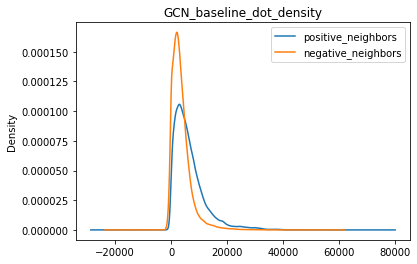

In [9]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 240.49it/s]


((1346155, 2), 9.63149563353299e-06, 0.6840151953513257, 0.1596295039176081)

# GCN ( baseline + crosswalk)

In [11]:
model = "GCN_baseline_crosswalk"
emb = np.load(DATA_ROOT + 'pokec_crosswalk_gcn_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 251348.78it/s]


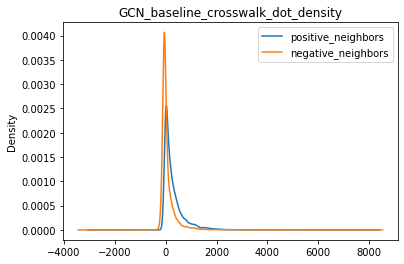

In [12]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 237.11it/s]


((1346155, 2), 1.298485667018811e-05, 0.7543522615931605, 0.20321475464360594)

# GCN ( r2v)

In [14]:
model = "GCN_r2v"
emb = np.load(DATA_ROOT + 'pokec_gcn_r2v_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 244734.20it/s]


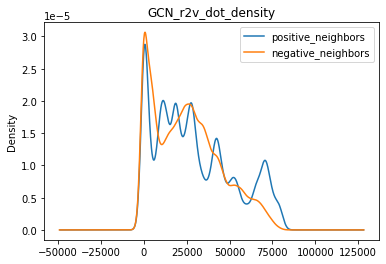

In [15]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 202.27it/s]


((1346155, 2), 1.4076734939764739e-05, 0.5434093021983889, 0.21958432890103521)

# GCN ( r2v + crosswalk)

In [17]:
model = "GCN_r2v_crosswalk"
emb = np.load(DATA_ROOT + 'pokec_crosswalk_gcn_r2v_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 243310.56it/s]


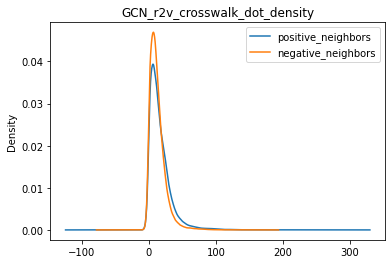

In [18]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 224.02it/s]


((1346155, 2), 1.4326590300167318e-05, 0.563763778935924, 0.22362620441601358)

# GAT ( baseline)

In [20]:
model = "GAT_baseline"
emb = np.load(DATA_ROOT + 'pokec_gat_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 246843.76it/s]


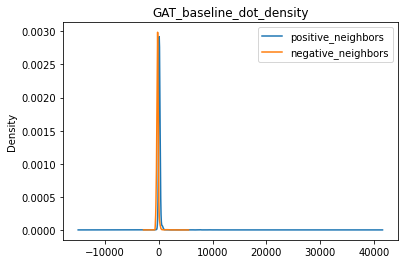

In [21]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 239.10it/s]


((1346155, 2), 1.2119709134570843e-05, 0.9519802951694476, 0.18594774443323323)

# GAT ( baseline + crosswalk)

In [23]:
model = "GAT_baseline_crosswalk"
emb = np.load(DATA_ROOT + 'pokec_crosswalk_gat_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 249586.34it/s]


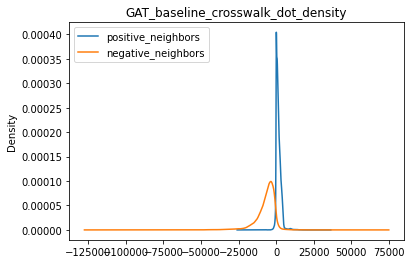

In [24]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 151.67it/s]


((1346155, 2), 7.469470547818158e-06, 0.9748799850906155, 0.129252441779997)

# GAT ( r2v)

In [26]:
model = "GAT_r2v"
emb = np.load(DATA_ROOT + 'pokec_gat_r2v_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 244030.06it/s]


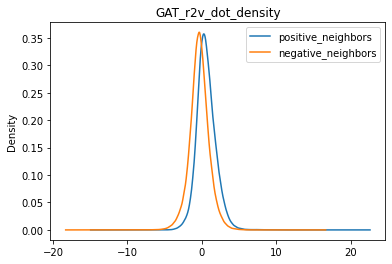

In [27]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 219.75it/s]


((1346155, 2), 1.1337318381481633e-05, 0.6993206244935993, 0.19199501029066504)

# GAT ( r2v + crosswalk)

In [29]:
model = "GAT_r2v_crosswalk"
emb = np.load(DATA_ROOT + 'pokec_crosswalk_gat_r2v_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|█████████████████████████████████████| 269231/269231 [00:01<00:00, 253091.92it/s]


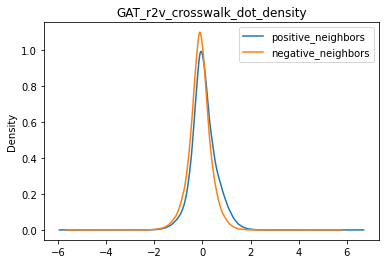

In [30]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████| 134/134 [00:00<00:00, 201.25it/s]


((1346155, 2), 1.695502449571635e-05, 0.5949927857362975, 0.26180716923393954)

# plot statistical parity scores

# gini sp scores

GCN_baseline 0.1596295039176081
GCN_baseline_crosswalk 0.20321475464360594
GCN_r2v 0.21958432890103521
GCN_r2v_crosswalk 0.22362620441601358
GAT_baseline 0.18594774443323323
GAT_baseline_crosswalk 0.129252441779997
GAT_r2v 0.19199501029066504
GAT_r2v_crosswalk 0.26180716923393954


[Text(0, 0, 'GCN_baseline'),
 Text(1, 0, 'GCN_baseline_crosswalk'),
 Text(2, 0, 'GCN_r2v'),
 Text(3, 0, 'GCN_r2v_crosswalk'),
 Text(4, 0, 'GAT_baseline'),
 Text(5, 0, 'GAT_baseline_crosswalk'),
 Text(6, 0, 'GAT_r2v'),
 Text(7, 0, 'GAT_r2v_crosswalk')]

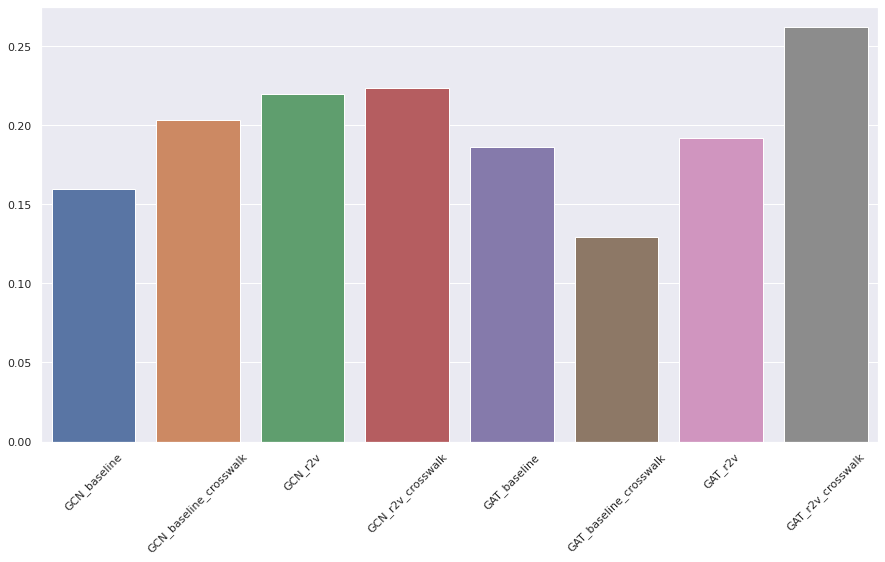

In [32]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

# sp scores

GCN_baseline 9.63149563353299e-06
GCN_baseline_crosswalk 1.298485667018811e-05
GCN_r2v 1.4076734939764739e-05
GCN_r2v_crosswalk 1.4326590300167318e-05
GAT_baseline 1.2119709134570843e-05
GAT_baseline_crosswalk 7.469470547818158e-06
GAT_r2v 1.1337318381481633e-05
GAT_r2v_crosswalk 1.695502449571635e-05


[Text(0, 0, 'GCN_baseline'),
 Text(1, 0, 'GCN_baseline_crosswalk'),
 Text(2, 0, 'GCN_r2v'),
 Text(3, 0, 'GCN_r2v_crosswalk'),
 Text(4, 0, 'GAT_baseline'),
 Text(5, 0, 'GAT_baseline_crosswalk'),
 Text(6, 0, 'GAT_r2v'),
 Text(7, 0, 'GAT_r2v_crosswalk')]

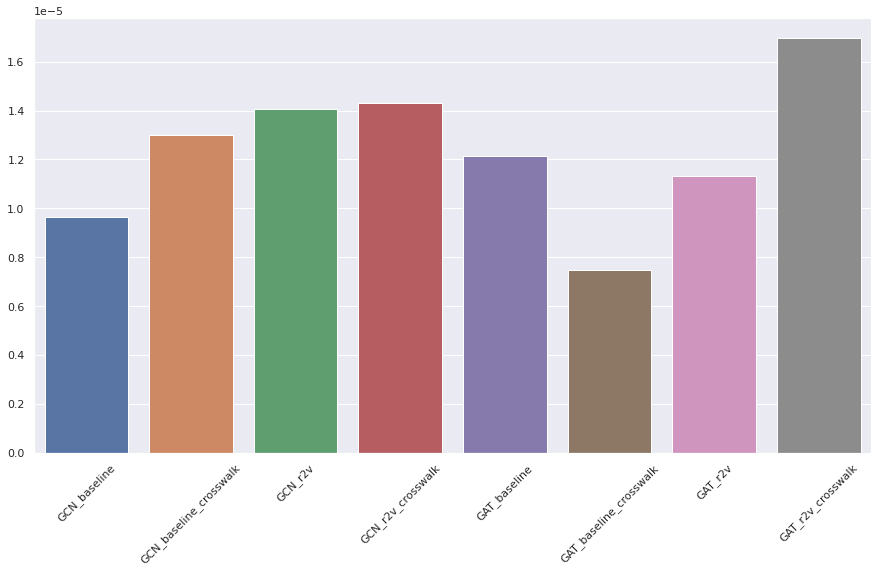

In [33]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

# roc auc scores

GCN_baseline 0.6840151953513257
GCN_baseline_crosswalk 0.7543522615931605
GCN_r2v 0.5434093021983889
GCN_r2v_crosswalk 0.563763778935924
GAT_baseline 0.9519802951694476
GAT_baseline_crosswalk 0.9748799850906155
GAT_r2v 0.6993206244935993
GAT_r2v_crosswalk 0.5949927857362975


[Text(0, 0, 'GCN_baseline'),
 Text(1, 0, 'GCN_baseline_crosswalk'),
 Text(2, 0, 'GCN_r2v'),
 Text(3, 0, 'GCN_r2v_crosswalk'),
 Text(4, 0, 'GAT_baseline'),
 Text(5, 0, 'GAT_baseline_crosswalk'),
 Text(6, 0, 'GAT_r2v'),
 Text(7, 0, 'GAT_r2v_crosswalk')]

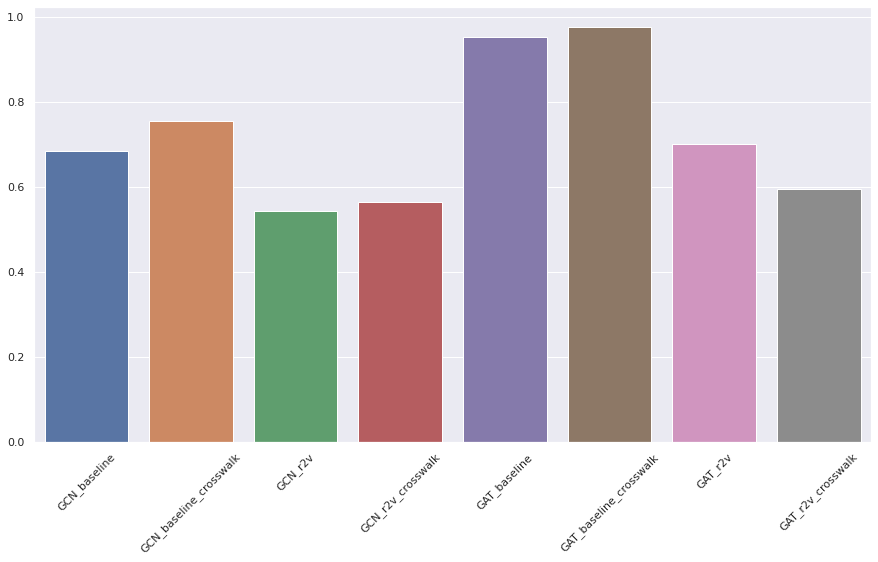

In [34]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)